# Problem 3:
## citation : Code inspired from 
https://medium.com/analytics-vidhya/step-by-step-implementation-of-conditional-generative-adversarial-networks-54e4b47497d6

In [1]:
import torchvision
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import numpy as np
import pandas as pd
from random import sample
from torch.autograd import Variable 
from random import randint
from torch import optim as optim

import pickle as pkl

import matplotlib.pyplot as plt

In [2]:
#use gpu if available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [3]:

#Train and test data
mnist_train=torchvision.datasets.MNIST('mnist',
                                       train=True,
                                       download=True,
                                       transform=torchvision.transforms.Compose([
                                           torchvision.transforms.ToTensor(),
                                           torchvision.transforms.Normalize((0.5,), (0.5, ))
                                       ]))


mnist_= torchvision.datasets.MNIST('mnist',
                          train=False,
                          download=True,
                          transform=torchvision.transforms.Compose([
                              torchvision.transforms.ToTensor(),
                              torchvision.transforms.Normalize((0.5, ), (0.5, ))
                          ])
                          )

In [4]:
batch_size = 64

#creating a dataloader
train_dataloader = DataLoader(mnist_train, batch_size=batch_size)
test_dataloader = DataLoader(mnist_, batch_size=batch_size)
flatten = nn.Flatten()
#Testing the size of each input
print(len(test_dataloader))
for X, y in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    print('flatten shape', flatten(X).shape)
    break

157
Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64
flatten shape torch.Size([64, 784])



 Epoch 0: descriminator loss 0.20478753745555878, generator loss 2.395400285720825

 --Test error real images: 0.00032679718349439403 --

 --Test error fake images: 0.0011851416149487098 --

 correct -- 0.9915833333333334, fake -- 1.0

 Epoch 1: descriminator loss 0.09288083761930466, generator loss 3.9450700283050537

 --Test error real images: 0.001251872026361525 --

 --Test error fake images: 0.0021697161530454955 --

 correct -- 0.9543833333333334, fake -- 0.9996333333333334

 Epoch 2: descriminator loss 0.07476191967725754, generator loss 4.323214530944824

 --Test error real images: 0.0009257142564126601 --

 --Test error fake images: 0.00018649778102214137 --

 correct -- 0.9655166666666667, fake -- 1.0

 Epoch 3: descriminator loss 0.029354143887758255, generator loss 5.552960395812988

 --Test error real images: 0.0013388520699266033 --

 --Test error fake images: 3.414018577702033e-05 --

 correct -- 0.9502166666666667, fake -- 1.0

 Epoch 4: descriminator loss 0.0293286386

/N/u/potem/Quartz/miniconda3/lib/python3.9/site-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/N/u/potem/Quartz/miniconda3/lib/python3.9/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


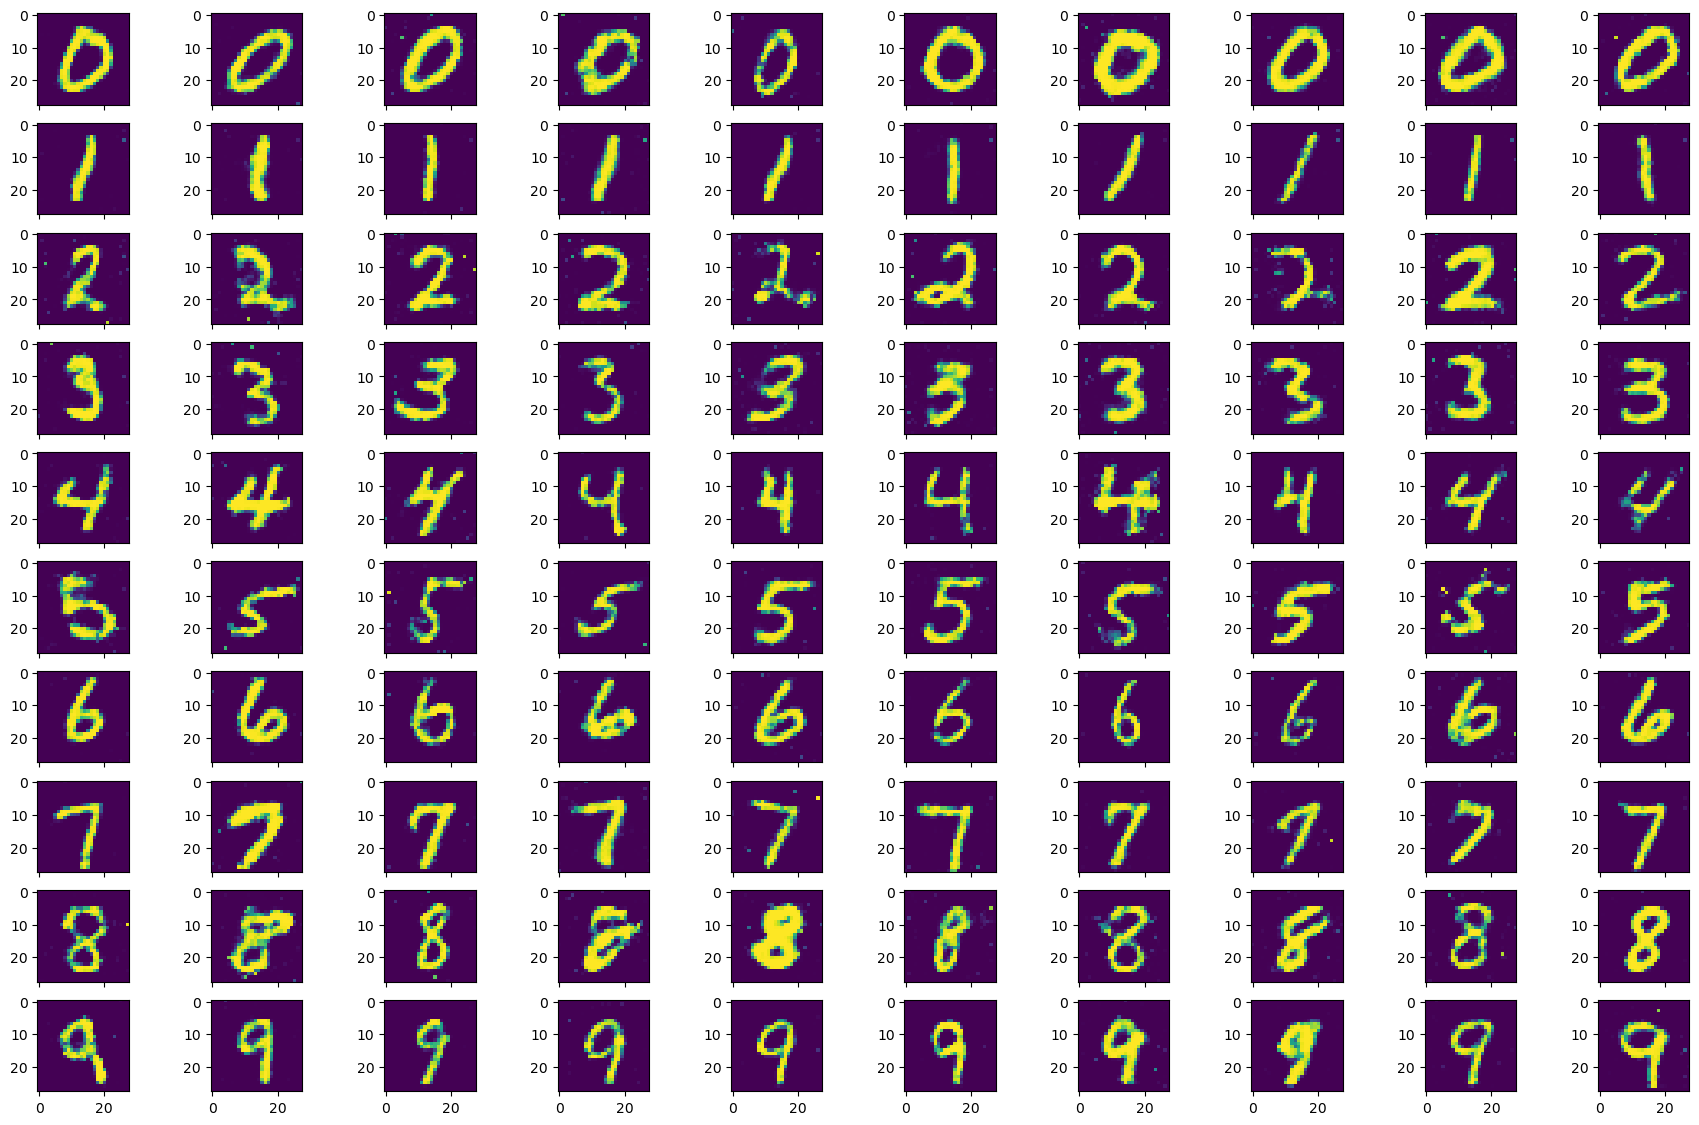

In [10]:
class PrepareData(Dataset):
    def __init__(self, X, y):
        super(PrepareData, self).__init__()
        self.X = X
        self.y = y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
    
    
def stack_data(data, save=True, type_of='train'):
    new_x_tensor = []
    new_y_tensor = []
    
    for x, y in data:
        x = torch.flatten(x, start_dim=1)
        y = torch.tensor(y, dtype=torch.long)
            
        new_x_tensor.append(x)
        new_y_tensor.append(y)
        
    new_x_tensor = torch.stack(new_x_tensor)
    new_x_tensor = new_x_tensor.squeeze()
    
    new_y_tensor = torch.stack(new_y_tensor)
    
    if save == True:
        torch.save(new_x_tensor, f'hw5_raw_{type_of}_x.pt')
        torch.save(new_y_tensor, f'hw5_raw_{type_of}_y.pt')
        
    return new_x_tensor, new_y_tensor



def append_label(data, save=True, type_of='train'):
    new_x_tensor = []
    new_y_tensor = []
    labels = F.one_hot(torch.arange(0, 10), 
                       num_classes=10)
    new_label = []
    for x, y in data:
        x = torch.flatten(x, start_dim=1)
        x = x.squeeze()
        label_y = labels[y]
        
        x = torch.cat((x, label_y))
        y = torch.tensor(y, dtype=torch.long)
       
        new_x_tensor.append(x)
        new_y_tensor.append(y)
        new_label.append(label_y)
        
        
    new_x_tensor = torch.stack(new_x_tensor)
    
    new_y_tensor = torch.stack(new_y_tensor)
    new_label = torch.stack(new_label)
    
    # if save == True:
    #     torch.save(new_x_tensor, f'hw5_prb3_{type_of}_x.pt')
    #     torch.save(new_y_tensor, f'hw5_prb3_{type_of}_y.pt')
    #     torch.save(new_label, f'hw5_prb3_{type_of}_label.pt')
        
    return new_x_tensor, new_y_tensor, new_label




def plot_image_single(data_loader):
    for x,_ in data_loader:
        plt.imshow(x.numpy()[0][0], cmap='gray')
        break


class GeneratorModel(nn.Module):
    def __init__(self, parameters):
        super(GeneratorModel, self).__init__()
        
        label_dim = 10
        self.labels = F.one_hot(torch.arange(0, 10), 
                       num_classes=10)
        # self.label_embedding = nn.Embedding(10, 10)
        self.l1 = nn.Linear(parameters['in_dim'] + label_dim, 
                            parameters['hidden_dim_1']
                           )
        self.l2 = nn.Linear(parameters['hidden_dim_1'], 
                            parameters['hidden_dim_2'])
        self.l3 = nn.Linear(parameters['hidden_dim_2'], 
                            parameters['out_dim'])
        
        
    def forward(self, x, y):
        label = self.labels[torch.flatten(y)]
        
        x = torch.cat((x, label), 1)
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.tanh(self.l3(x))
        
        return x
    
    
class DiscriminatorModel(nn.Module):
    def __init__(self, parameters):
        super(DiscriminatorModel, self).__init__()
        
        label_dim = 10
        self.labels = F.one_hot(torch.arange(0, 10), 
                       num_classes=10)
        self.l1 = nn.Linear(parameters['out_dim'] + label_dim, 
                            parameters['hidden_dim_2']
                           )
        self.l2 = nn.Linear(parameters['hidden_dim_2'], 
                            parameters['hidden_dim_1'])
        self.l3 = nn.Linear(parameters['hidden_dim_1'], 
                            parameters['in_dim_des'])
        self.l4 = nn.Linear(parameters['in_dim_des'], 
                            parameters['out_dim_des'])
        
        
    def forward(self, x, y):
        label = self.labels[torch.flatten(y)]
        
        x = torch.cat((x, label), 1)
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = F.sigmoid(self.l4(x))
        
        return x
        
        
# def train(parameters):

def generate_data(batch_size, y, dim=100):
    labels = F.one_hot(torch.arange(0, 10), 
                       num_classes=10)
    no_of_batch = len(y)
    noise = torch.randn(no_of_batch, batch_size,dim).to(device)
    print(noise.shape)
    print(len(y))
    noise = torch.cat((noise, y), 2)
    print(noise.shape)
    
    
    return noise
   
    
def create_dataloader(x, y, batchsize):
    data = PrepareData(x, y)
   
    dataloader = DataLoader(dataset=data, shuffle=False, 
                      batch_size=batchsize)
    
    return dataloader


def prepare_data(train=mnist_train, 
                 label=True,
                 batchsize=100
                ):
    train_data_x, train_data_y = stack_data(mnist_train)
    
    train_loader = create_dataloader(train_data_x,
                                     train_data_y,
                                     batchsize)
    
    return train_loader  #, data_for_generator


def test_images():
    test_x = torch.load(f'hw5_raw_test_x.pt')
    test_y = torch.load(f'hw5_raw_test_y.pt')
    test_x = torch.squeeze(test_x)
    
    index = [i for i in range(test_x.shape[0])]

    df = pd.DataFrame()
    df['indices'] = index
    df['org_y'] = [test_y[i].tolist() for i in index]

    df_group = df.groupby(['org_y']).head(10).reset_index(drop=True)
    
    new_x_tensor = []
    new_y_tensor = []
    for i, row in df_group.iterrows():
        x = test_x[row['indices']]
        x = split_image(x)
        y = torch.tensor(row['org_y'], dtype=torch.long)
            
        new_x_tensor.append(x)
        new_y_tensor.append(y)
        
    new_x_tensor = torch.stack(new_x_tensor)
    new_y_tensor = torch.stack(new_y_tensor)
    
#     df_groups = df_group.groupby(['org_y'])

#     fig_name = 'hw5_images_10x10.png'
#     fontsize=12
#     column = 10
#     row = 10

    # plot_images(df_groups, column, row, fig_name, test_x)
    
    return new_x_tensor, new_y_tensor, df_group


def test(test_dataloader, model, loss, y):
    model.eval()
    model.to(device)
    
    total_loss = 0
    correct = 0
    size = len(test_dataloader.dataset)
    
    with torch.no_grad():
        for j, (x_test, y_test) in enumerate(test_dataloader):
            pred = model(x_test, y_test).to(device)
            
            total_loss += loss(pred, y).item()
            pred = torch.where(pred >0.5, 1, 0)
            
            correct += (pred == y).type(torch.float).sum().item()
        
    total_loss /= size
    correct /= size
    
    print(f'\n --Test error real images: {total_loss} --')
    
    return correct
        

def generat_label():
    labels = []

    for r in range(10):
        for rr in range(10):
            labels.append(r)
        
        
    return torch.tensor(labels)
    
def test_fake(generator, discriminator, loss, parameters):
    generator.eval()
    discriminator.eval()
    
    total_loss = 0
    correct = 0
    size = 60000
    
    with torch.no_grad():
        for i in range(600):
            noise = torch.randn(parameters['batch'], 100)
            # fake_labels = torch.randint(0, 10, (parameters['batch'],))
            fake_labels = generat_label()
            generated_data = generator(noise, fake_labels)

            y_test = torch.zeros(parameters['batch']).reshape(100, 1).type(
                        torch.float)

            pred = discriminator(generated_data, 
                                 fake_labels)
            total_loss += loss(pred, y_test).item()
            
            pred = torch.where(pred >0.5, 1, 0)
            
            # correct += (pred == y_test).type(torch.float).sum().item()
            correct += torch.eq(pred, y_test).sum().item()
    
    total_loss /= size
    correct /= size 
    
    print(f'\n --Test error fake images: {total_loss} --')

    return correct


def plot_images(column, row, 
                fig_name, input_x
               ):
    j = 0
    k = 0
    indexes = 0
    fig, ax = plt.subplots(row, column, figsize=(22, 14), sharex=True)

    for i in range(row):
        for j in range(column):
            new_ax = ax[i, j]
            
            new_ax.imshow(input_x[indexes].detach().numpy())
            indexes = indexes + 1
            
    fig.savefig(f'{fig_name}', 
            facecolor='white', 
            transparent=False)

    plt.show()
    
def process(parameters):
    train_dataloader = prepare_data(train=mnist_train,
                                    label=False,
                                    batchsize=parameters['batch']
                                   )
                                      
    test_dataloader = prepare_data(train=mnist_,
                                    label=False,
                                    batchsize=parameters['batch']
                                   )
    all_pred = []
    
    # for  y in label_loader:
    #     print(y.shape)
    #     break
    
    generator = GeneratorModel(parameters)
    discriminator = DiscriminatorModel(parameters)
    
    loss = nn.BCELoss()
    discriminator_optimizer = optim.Adam(
        discriminator.parameters(), lr=0.0001)
    generator_optimizer = optim.Adam(
        generator.parameters(), lr=0.0001)

    for t in range(parameters['epoch']):
        total_g_loss = []
        total_d_loss = []
        
        for i, (x, y) in enumerate(train_dataloader):
            #Generator part
            noise =  torch.randn(parameters['batch'],
                                 100)
            # fake_labels = torch.randint(0, 10, (parameters['batch'],))
            fake_labels = generat_label()
            
            generation_data = generator(noise, fake_labels)
            
            #Discriminator part
            discriminator_optimizer.zero_grad()
            
            y_reshape = y.reshape(100, 1).type(
                torch.float)
            
            true_labels = torch.ones(parameters['batch']).reshape(100, 1).type(
                torch.float)
            
            descrimination_data = discriminator(x, y)
            descrimination_loss = loss(descrimination_data, 
                                       true_labels)
            
            descrimination_generation_data = discriminator(generation_data.detach(), 
                                                           fake_labels)
            zero_y = torch.zeros(parameters['batch']).reshape(100, 1).type(
                torch.float)
            descrimination_generation_loss = loss(descrimination_generation_data,
                                                  zero_y)
            discriminator_loss = (descrimination_loss + descrimination_generation_loss) / 2
        
            discriminator_loss.backward()
            discriminator_optimizer.step()

            total_d_loss.append(discriminator_loss.data.item())
                              
            #Generator training
            generator_optimizer.zero_grad()
            
            generation_data = generator(noise, fake_labels)
            descrimination_generation_data = discriminator(generation_data, 
                                                           fake_labels)
            
            generator_loss = loss(descrimination_generation_data, 
                                  true_labels)
            generator_loss.backward()
            generator_optimizer.step()
        
            total_g_loss.append(generator_loss.data.item())
            
        mean_d_loss = torch.mean(torch.FloatTensor(total_d_loss))
        mean_g_loss = torch.mean(torch.FloatTensor(total_g_loss))

        print(f'\n Epoch {t}: descriminator loss {mean_d_loss}, generator loss {mean_g_loss}')
        
        y_test = torch.ones(parameters['batch']).reshape(100, 1).type(
                torch.float)
        
        correct_true = test(test_dataloader, discriminator, loss, y_test)
        correct_false = test_fake(generator, discriminator, loss, parameters)
        
        print(f'\n correct -- {correct_true}, fake -- {correct_false}')
        
        all_pred.append([t, correct_true, correct_false])
        
        if t == 299: #t % 10 == 0:
            print(f'\n Epoch {t}:')
            
            (pd.DataFrame(data = all_pred, 
                         columns=['epoch', 'true', 'false'])
             .to_pickle('hw5-qns-3-accuracy.pkl.gz')
            )

            with torch.no_grad():
                
                noise = torch.randn(100, 100)
                fake_labels = generat_label()#torch.randint(0, 10, (parameters['batch'],))
                # fake_labels = torch.tensor([r for r in range(10)])
                generated_data = generator(noise, fake_labels)
                
                pred = discriminator(generated_data, 
                                     fake_labels)
                # print(pred)
                generated_data = generated_data.view(
                    100, 28, 28)
                
                # for rr, x in enumerate(generated_data):
                #     print(fake_labels[rr].item())
                #     plt.imshow(x.detach().numpy(), 
                #                interpolation='nearest',cmap='gray')
                #     plt.show()

#                     break
                plot_images(10, 10, 'hw5-qns3.png', generated_data.detach())

       
           
#             break
#         break
                                        
    
parameters = {
    'in_dim': 100,
    'hidden_dim_1': 200,
    'hidden_dim_2': 400,
    'in_dim_des': 100,
    'out_dim': 784,
    'out_dim_des': 1,
    # 'baseline_model': 'hw_4_baseline.model',
    'batch': 100,
    'num_layers': 2,
    'type_init': 'xavier',
    'activation': 'ReLU',
    'dropout': None,
    "lr_rate": 0.01,
    'epoch': 300,
    'latent_dim': 3,
    'd_vector': 100
}
    
process(parameters)

In [16]:
df = pd.read_pickle('hw5-qns-3-accuracy.pkl.gz')

print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   epoch   300 non-null    int64  
 1   true    300 non-null    float64
 2   false   300 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 7.2 KB
None
   epoch      true     false
0      0  0.991583  1.000000
1      1  0.954383  0.999633
2      2  0.965517  1.000000
3      3  0.950217  1.000000
4      4  0.967450  1.000000


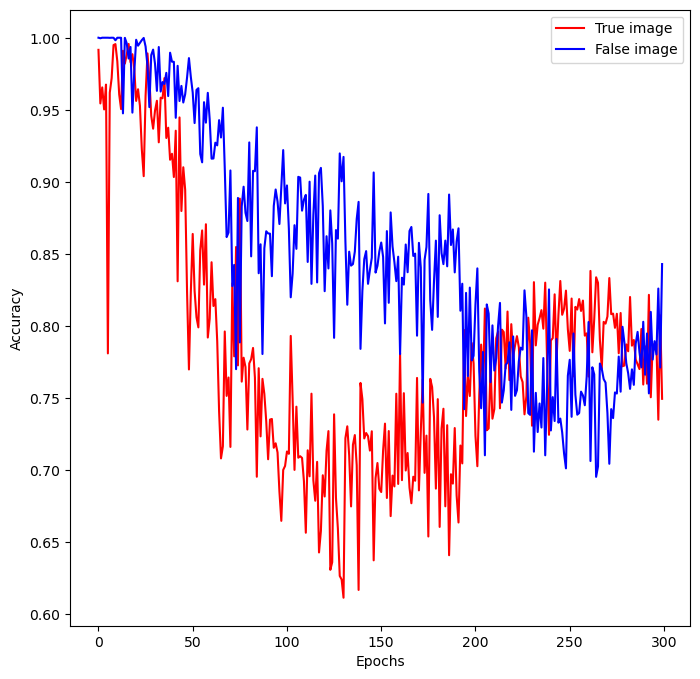

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax.plot(df['epoch'], df['true'], color='red', 
        label='True image')
ax.plot(df['epoch'], df['false'], color='blue',
        label='False image'
       )
ax.legend()
fig.savefig(f'{fig_name}', 
        facecolor='white', 
        transparent=False)

ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')

plt.show()